In [1]:
import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/crystal/miniconda3/envs/openmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

In [3]:
!pwd

/home/crystal/Desktop/deca56D


In [4]:
traj = md.load_dcd('deca56D_prd.dcd', top='deca56D_clean.pdb')

In [5]:
traj= md.Trajectory.superpose(traj, traj[0], frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)

subset_traj = traj[1642400:1642700]
subset_traj.save('bottleneckframes.pdb')

def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

radgyr(protein, u.trajectory)

traj = traj.superpose(traj[0])

protein = u.select_atoms('protein')

protein

rog = AnalysisFromFunction(radgyr, u.trajectory,
                           protein, protein.masses,
                           total_mass=np.sum(protein.masses))
rog.run()

In [6]:
rmsd = md.rmsd(traj, traj[0], frame=0, atom_indices=None, parallel=True, precentered=False)*10

In [7]:
rmsd2 = md.rmsd(traj, traj[1642600], frame=0, atom_indices=None, parallel=True, precentered=False)*10

np.save('56DRMSD.npy',rmsd)

rmsd = np.load('56DRMSD.npy', allow_pickle=True)

mda_rg = rog.results['timeseries'][:,0]

rg = md.compute_rg(traj)

np.save('mda_rg.npy', mda_rg)

In [8]:
mda_rg = np.load('mda_rg.npy')

md.rmsf(traj, traj[0], frame=0, atom_indices=None, parallel=True, precentered=False)

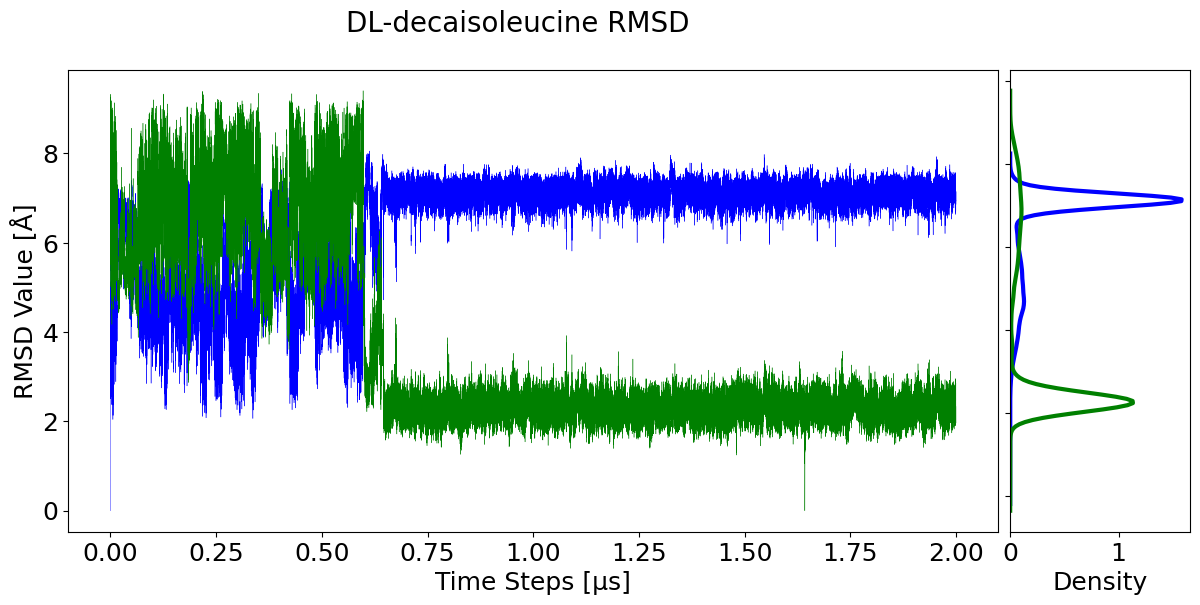

In [11]:
from pylab import *
from math import pi
time_steps = np.arange(0, 2000000)
fig, ax = plt.subplots(figsize=(12,6))
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                            0.15, ax.get_position().height])

ax.plot(time_steps/1000000, rmsd, marker='o', markersize=0, linestyle='-', lw=0.3, label='posetraj[0]', color='blue')
ax.plot(time_steps/1000000, rmsd2, marker='o', markersize=0, linestyle='-', lw=0.3, label='posetraj[1647896]', color='green')
ax.set_xlabel('Time Steps [µs]', fontsize = 18)
ax.set_ylabel('RMSD Value [Å]', fontsize = 18)
ax.tick_params(labelsize = 18)
sns.kdeplot(y = rmsd, ax = inty_ax, lw=3, color='blue')
sns.kdeplot(y = rmsd2, ax = inty_ax, lw=3, color='green')
inty_ax.set_xlabel('Density', fontsize=18)
inty_ax.tick_params(labelleft = False, labelsize = 18)
fig.suptitle('DL-decaisoleucine RMSD', fontsize = 20)
plot_filename = f'56D-decapeptide RMSD.png'
plt.savefig(plot_filename, bbox_inches='tight', dpi=600)
plt.show()

In [11]:
plt.rcParams.update(mpl.rcParamsDefault)
#plt.rcParams['text.usetex'] = True

from pylab import *
from math import pi
time_steps = np.arange(0, 2000000)

# Plotting RG graph
fig, ax = plt.figure(figsize=(12, 6))
plt.plot(time_steps/1000000, mda_rg, marker='o', markersize=0, linestyle='-')
plt.title('56D-decapeptide R_g', fontsize = 20)
plt.xlabel('Time Steps [us]', fontsize = 15)
plt.ylabel('Radius of gyration [Å]', fontsize = 15)
#plt.xlim([0,2000000])
#plt.ylim([0.5,1.1])
plot_filename = f'56D-decapeptide RG.png'
plt.savefig(plot_filename, dpi=600)
plt.show()

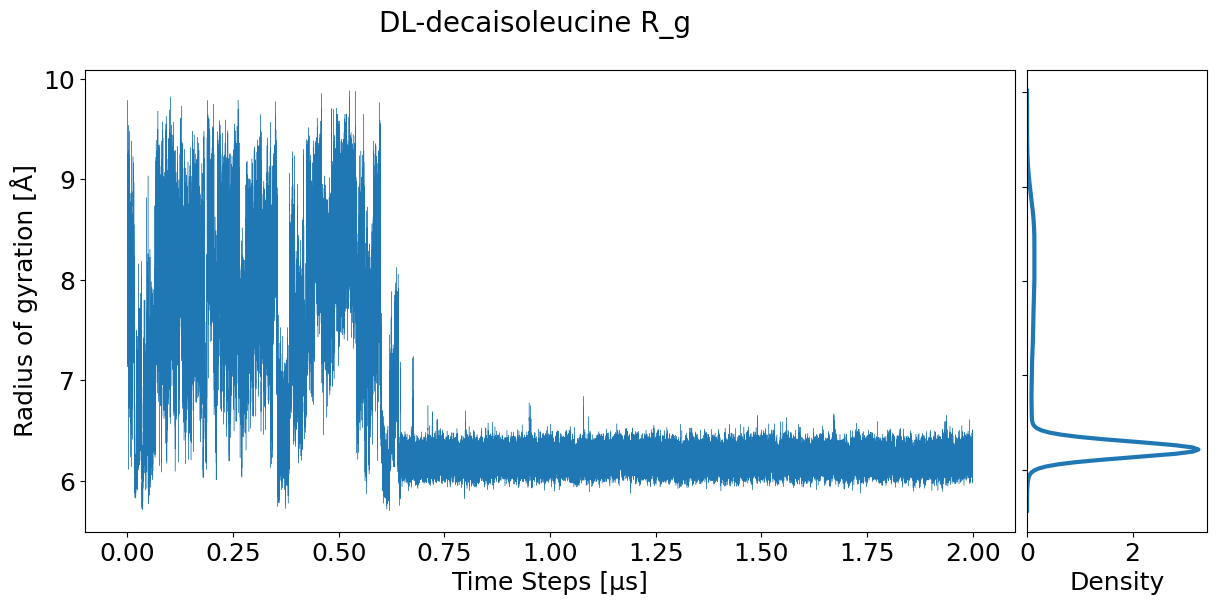

In [14]:
from pylab import *
from math import pi
time_steps = np.arange(0, 2000000)

fig, ax = plt.subplots(figsize=(12, 6))
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                            0.15, ax.get_position().height])

ax.plot(time_steps/1000000, mda_rg, marker='o', markersize=0, linestyle='-', lw=0.3)
ax.set_xlabel('Time Steps [µs]', fontsize = 18)
ax.set_ylabel('Radius of gyration [Å]', fontsize = 18)
ax.tick_params(labelsize = 18)
sns.kdeplot(y = mda_rg, ax = inty_ax, lw=3)
inty_ax.set_xlabel('Density', fontsize=18)
inty_ax.tick_params(labelleft = False, labelsize = 18)

fig.suptitle('DL-decaisoleucine R_g', fontsize = 20)
plot_filename = f'56D-decapeptide RG.png'
plt.savefig(plot_filename, bbox_inches='tight',dpi=600)
plt.show()

num_frames = min(traj.n_frames, 750000)  # Limit to the first 750,000 frames

selected_frames = range(0, num_frames, 7500)
selected_traj = traj[selected_frames]

# Save the selected trajectories into a new PDB file
selected_traj.save_pdb('selected_trajectory.pdb')

md.compute_phi(traj)

md.compute_psi(traj)

psi_indices = [[  0,   4,   6,  21],
        [ 21,  23,  25,  40],
        [ 40,  42,  44,  59],
        [ 59,  61,  63,  78],
        [ 78,  80,  82,  97],
        [ 97,  99, 101, 116],
        [116, 118, 120, 135],
        [135, 137, 139, 154],
        [154, 156, 158, 173]]
phi_indices = [[  6,  21,  23,  25],
        [ 25,  40,  42,  44],
        [ 44,  59,  61,  63],
        [ 63,  78,  80,  82],
        [ 82,  97,  99, 101],
        [101, 116, 118, 120],
        [120, 135, 137, 139],
        [139, 154, 156, 158],
        [158, 173, 175, 177]]
angles = []
for i in range(min(len(phi_indices), len(psi_indices))):
    phi_set = phi_indices[i]
    psi_set = psi_indices[i]
    angles.append(md.compute_dihedrals(traj, [phi_set, psi_set]))
print(angles)

from pylab import *
from math import pi
for i in range(len(angles)):
    phi_values = angles[i][:, 0]
    psi_values = angles[i][:, 1]
    phi_set = phi_indices[i]
    psi_set = psi_indices[i]
    plt.figure(figsize=(8, 6))
    plt.scatter(phi_values, psi_values, c=traj.time, marker='x')
    plt.colorbar(label='Time [ps]')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.xlim([-pi, pi])
    plt.ylim([-pi, pi])
    plt.title(f'56D-decaisoleucine dihedral angle map for Phi {phi_set} and Psi {psi_set}')
    plot_filename = f'56D-ile dihedral_plot_{i+1}.png'
    plt.savefig(plot_filename, dpi=300)
    plt.show()

import pyemma as pm
for i in range(len(angles)):
    phi_values = angles[i][:, 0]
    psi_values = angles[i][:, 1]
    phi_set = phi_indices[i]
    psi_set = psi_indices[i]
    fig, ax = plt.subplots(figsize=(7,6),tight_layout=True)
    fes = pm.plots.plot_free_energy(phi_values*180/math.pi, psi_values*180/math.pi, nbins=100, ax=ax)
    ax.set_xlim([-180, 180])
    ax.set_ylim([-180, 180])
    ax.set_xlabel(r'$\Phi$ Angle (degree)', fontsize =15)
    ax.set_ylabel(r'$\Psi$ Angle (degree)', fontsize =15)
    ax.xaxis.set_ticks([-180,-120,-60,0,60,120,180])
    ax.yaxis.set_ticks([-180,-120,-60,0,60,120,180])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title(f'56D-decaisoleucine free energy plot for Phi {phi_set} and Psi {psi_set}')
    plot_filename = f'56D-decaI free_energy_plot_{i+1}.png'
    plt.savefig(plot_filename, dpi=300)
    plt.show()

import pyemma as pm
for i in range(len(angles)):
    phi_values = angles[i][:, 0]
    psi_values = angles[i][:, 1]
    phi_set = phi_indices[i]
    psi_set = psi_indices[i]
    fig, ax = plt.subplots(figsize=(7,6),tight_layout=True)
    fes = pm.plots.plot_free_energy(phi_values*180/math.pi, psi_values*180/math.pi, nbins=100, ncontours=3, ax=ax)
    ax.set_xlim([-180, 180])
    ax.set_ylim([-180, 180])
    ax.set_xlabel(r'$\Phi$ Angle (degree)', fontsize =15)
    ax.set_ylabel(r'$\Psi$ Angle (degree)', fontsize =15)
    ax.xaxis.set_ticks([-180,-120,-60,0,60,120,180])
    ax.yaxis.set_ticks([-180,-120,-60,0,60,120,180])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title(f'56D-decaisoleucine contour plot for Phi {phi_set} and Psi {psi_set}')
    plot_filename = f'56D-decaI contour_plot_{i+1}.png'
    plt.savefig(plot_filename, dpi=300)
    plt.show()

angles.shape

from pylab import *
from math import pi

figure()
title('Dihedral Map: L-Isoleucine dipeptide')
scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
cbar = colorbar()
cbar.set_label('Time [ps]')
xlabel(r'$\Phi$ Angle [radians]')
xlim(-pi, pi)
ylabel(r'$\Psi$ Angle [radians]')
ylim(-pi, pi)

fig, ax = plt.subplots(figsize=(6,6),tight_layout=True)
_,_,_,hist = ax.hist2d(angles[:, 0]*180/math.pi, angles[:, 1]*180/math.pi, bins=60, range=[[-180,180],[-180,180]])
ax.set_xlim([-180, 180])
ax.set_ylim([-180, 180])
ax.set_xlabel(r'$\Phi$ Angle', fontsize =15)
ax.set_ylabel(r'$\Psi$ Angle', fontsize =15)
ax.set_title('Dihedral Map: L-Isoleucine dipeptide', fontsize =18)
ax.xaxis.set_ticks([-180,-120,-60,0,60,120,180])
ax.yaxis.set_ticks([-180,-120,-60,0,60,120,180])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('L-Isoleucine dipeptide_dihedrals.png', dpi=600)

int(angles.shape[0]/100)

np.arange(0, int(angles.shape[0]/100)+1, 10)

np.arange(0, int(angles.shape[0]/100)+1, 100).shape

np.arange(0, int(angles.shape[0])+1, 10000).shape

from pylab import *
from math import pi
psi = angles[:, 1].flatten()
phi = angles[:, 0].flatten()

fig, axes = plt.subplots(2,1, figsize=(20,8))

axes[0].plot(psi, lw=0.5)
axes[1].plot(phi, lw=0.5)
axes[0].set_title('L-Isoleucine dipeptide', fontsize =18)
axes[0].set_ylabel(r'$\Psi$ Angle [radians]')
axes[1].set_ylabel(r'$\Phi$ Angle [radians]')
axes[1].set_xlabel('Time (ns)')
axes[0].set_xlabel('Time (ns)')

for ax in axes:
    ax.set_xticks(ticks=np.arange(0, int(angles.shape[0])+1, 10000), labels=np.arange(0, int(angles.shape[0]/100)+1, 100))
    ax.set_xlim([0, angles.shape[0]])

def find_transitions(s1_mask, s2_mask):
    s2s1_transition_ids, s1s2_transition_ids = [], []
    for i in tqdm(range(1, len(s1_mask)), desc=f'Finding transitions'):
        s1_ids = [k for k, x in enumerate(s1_mask[:i]) if x]
        s2_ids = [k for k, x in enumerate(s2_mask[:i]) if x]
        if len(s1_ids) == 0 or len(s2_ids) == 0:
            continue
        if s1_mask[i] and (s1_ids[-1] < s2_ids[-1]):
            s2s1_transition_ids.append([s2_ids[-1], i])
            with open('s2s1.txt', 'a') as f:
                # Write the list of strings to the file
                f.writelines(str(s2_ids[-1]) + ' ' + str(i) + '\n')
        if s2_mask[i] and (s1_ids[-1] > s2_ids[-1]):
            s1s2_transition_ids.append([s1_ids[-1], i])
            with open('s1s2.txt', 'a') as f:
                # Write the list of strings to the file
                f.writelines(str(s1_ids[-1]) + ' ' + str(i) + '\n')
    return s2s1_transition_ids, s1s2_transition_ids

def save_transitions(traj, s2s1_transition_ids, s1s2_transition_ids):
    if len(s2s1_transition_ids)>0:
        for no, ids in enumerate(s2s1_transition_ids):
            transition_traj = traj[ids[0]:ids[1]+1]
            transition_traj.superpose(transition_traj[0])
            transition_traj.save_pdb(md_transition_path.joinpath(f'traj_s2s1slowest{no}.pdb'))
    if len(s1s2_transition_ids)>0:
        for no, ids in enumerate(s1s2_transition_ids):
            transition_traj = traj[ids[0]:ids[1]+1]
            transition_traj.superpose(transition_traj[0])
            transition_traj.save_pdb(md_transition_path.joinpath(f'traj_s1s2slowest{no}.pdb'))
    return None

from tqdm import tqdm

from pathlib import Path

md_transition_path = Path('./')

find_transitions(phi>0.5, phi<-1.5)

s2s1_transition_ids = [[19998, 20001],
  [21827, 21829],
  [60214, 60216],
  [62125, 62127],
  [65936, 65939],
  [93265, 93268]]
s1s2_transition_ids =  [[3814, 3816],
  [20039, 20042],
  [22030, 22032],
  [60421, 60423],
  [62262, 62264],
  [66166, 66168],
  [93313, 93315]]
save_transitions(traj, s2s1_transition_ids, s1s2_transition_ids)